# How to Automate Data Cleaning with AI <a id="make-a-data-cleaning-agent"></a>

In this tutorial, you will learn how to automate data cleaning with AI. It can automatically:

- detect and fix common data cleaning issues
- missing values
- duplicate rows
- inconsistent data types. 
 
By using this AI agent, you can save time and effort on data cleaning, allowing you to focus on more important tasks.

### Want To Become A Full-Stack Generative AI Data Scientist?

![Generative AI Data Scientist](../img/become_a_generative_ai_data_scientist.jpg)

I teach Generative AI Data Science to help you build AI-powered data science apps. [**Register for my next Generative AI for Data Scientists workshop here.**](https://learn.business-science.io/ai-register)


# Table of Contents

1. [Make A Data Cleaning Agent](#make-a-data-cleaning-agent)
2. [Load Libraries](#load-libraries)
3. [Setup AI and Logging](#setup-ai-and-logging)
4. [Load a Dataset](#load-a-dataset)
5. [Create The Agent](#create-the-agent)
6. [Response](#response)
7. [The cleaning recipe](#the-cleaning-recipe)
8. [Data Cleaner Function](#data-cleaner-function)
9. [Cleaned Data As Pandas Data Frame](#cleaned-data-as-pandas-data-frame)
10. [Free Generative AI Data Science Workshop](#free-generative-ai-data-science-workshop)

### Load Libraries <a id="load-libraries"></a>

In [1]:
# * Libraries

from langchain_openai import ChatOpenAI
import os
import yaml
import pandas as pd
from pprint import pprint

from ai_data_science_team.agents import DataCleaningAgent

### Setup AI and Logging <a id="setup-ai-and-logging"></a>

This section of code sets up the LLM inputs and the logging information. Logging is used to store AI-generated code and files during the AI Data Science Teams processing of files. 

*Important Note:* This example uses OpenAI's API. But any LLM can be used such as Anthropic or local LLMs with Ollama.

In [2]:
# * Setup

MODEL    = "gpt-4o-mini"
LOG      = True
LOG_PATH = os.path.join(os.getcwd(), "logs/")

os.environ["OPENAI_API_KEY"] = yaml.safe_load(open('../credentials.yml'))['openai']

llm = ChatOpenAI(model = MODEL)

llm


ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x7fa4807d5cf0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x7fa43060c730>, root_client=<openai.OpenAI object at 0x7fa4807d9300>, root_async_client=<openai.AsyncOpenAI object at 0x7fa4807d5000>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********'))

### Load a Dataset <a id="load-a-dataset"></a>

Next, let's load a customer churn data set that we will clean up. 

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/business-science/ai-data-science-team/refs/heads/master/data/churn_data.csv")
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


### Create The Agent <a id="create-the-agent"></a>

Run this code to create an agent with `make_data_cleaning_agent()`.

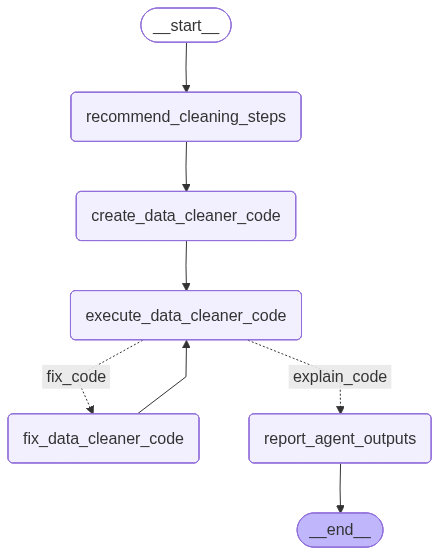

In [4]:
data_cleaning_agent = DataCleaningAgent(
    model = llm, 
    log=LOG, 
    log_path=LOG_PATH
)

data_cleaning_agent

This creates an `app`, which is a langgraph agent with the main inputs:

- **user_instructions**: The data cleaning agent will use these comments to modify the "standard recipe" 
  - Standard Recipe: The standard cleaning recipe which includes removing columns with more than 40% missing values, imputing missing values using mean (numeric) or mode (categorical), removing duplicate rows, and removing outliers. 
- **data_raw**: The raw data to be cleaned
- **max_retries**: Used to limit the number of attempts to fix the python code generated by the agent. Set this to 3 to limit to 3 attempts. 
- **retry_count**: Set this to 0. 

In [5]:
data_cleaning_agent.invoke_agent(
    data_raw=df,
    user_instructions="Don't remove outliers when cleaning the data.",
    max_retries=3,
    retry_count=0
)  

---DATA CLEANING AGENT----
    * RECOMMEND CLEANING STEPS
    * CREATE DATA CLEANER CODE
      File saved to: /Users/mdancho/Desktop/course_code/ai-data-science-team/logs/data_cleaner.py
    * EXECUTE DATA CLEANER CODE (SANDBOXED)
    * REPORT AGENT OUTPUTS


### Response <a id="response"></a>

The response produced contains everything we need to understand the data cleaning decisions made and get the cleaned dataset. 

In [6]:
response = data_cleaning_agent.get_response()

list(response.keys())

['messages',
 'user_instructions',
 'recommended_steps',
 'data_raw',
 'data_cleaned',
 'all_datasets_summary',
 'data_cleaner_function',
 'data_cleaner_function_path',
 'data_cleaner_file_name',
 'data_cleaner_function_name',
 'data_cleaner_error',
 'max_retries',
 'retry_count']

#### Cleaned Data As Pandas Data Frame <a id="cleaned-data-as-pandas-data-frame"></a>

Use the `get_data_cleaned()` method to get the cleaned data as a pandas data frame.

In [7]:
data_cleaning_agent.get_data_cleaned()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


#### Data Cleaner Function <a id="data-cleaner-function"></a>

We can use the `get_data_cleaner_function()` method to get the data cleaner function pipeline. 

- In Jupyter Notebooks, setting `markdown=True` will return the function as markdown code. 
- In Streamlit apps, it's recommended to set `markdown=False`.

In [8]:
data_cleaning_agent.get_data_cleaner_function(markdown=True)

```python
# Disclaimer: This function was generated by AI. Please review before using.
# Agent Name: data_cleaning_agent
# Time Created: 2025-12-08 17:28:19

def data_cleaner(data_raw):
    import pandas as pd
    import numpy as np


    # Step 1: Remove Columns with Excessive Missing Data
    # Since there's no missing data, this step is skipped.

    # Step 2: Impute Missing Values in Numeric Columns
    # All columns are non-null, so this step is skipped.

    # Step 3: Impute Missing Values in Categorical Columns
    # All columns are non-null, so this step is skipped.

    # Step 4: Convert Columns to Correct Data Type
    # Convert 'TotalCharges' from object to float
    data_raw['TotalCharges'] = pd.to_numeric(data_raw['TotalCharges'], errors='coerce')

    # Step 5: Remove Duplicate Rows
    data_raw.drop_duplicates(inplace=True)

    # Step 6: Remove Rows with Missing Values
    # Since there are no missing values, this step is skipped.

    # Step 7: Remove Rows with Extreme Outliers
    # This step is skipped as per user instruction.

    # Step 8: Analyze Data for Additional Cleaning Steps
    # No additional actions are necessary as the data is clean.

    # Return the cleaned DataFrame
    return data_raw
```

#### Recommended Steps

To get the recommended steps during the data analysis (prior to coding), run the `get_recommended_steps()` method.

In [9]:
data_cleaning_agent.get_recommended_cleaning_steps(markdown=True)

# Recommended Data Cleaning Steps:
Here is a series of numbered steps to clean and preprocess the provided dataset, tailored to its characteristics and user instructions:

1. **Remove Columns with Excessive Missing Data**:
   - Check the percentage of missing data for each column. Since all columns have 0.00% missing data, no columns are removed.

2. **Impute Missing Values in Numeric Columns**:
   - All columns in the dataset are non-null, so no imputation of missing values is necessary. 
   - If there were any numeric columns with missing values, the missing values would be imputed using the mean of the respective column.

3. **Impute Missing Values in Categorical Columns**:
   - Again, since all columns are non-null, no imputation is needed.
   - If there were categorical columns with missing values, missing values would be imputed using the mode of the respective column.

4. **Convert Columns to Correct Data Type**:
   - The `TotalCharges` column should be converted from object to float type for numeric operations:
     ```python
     df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
     ```

5. **Remove Duplicate Rows**:
   - Check for duplicate rows and remove them if found. 
   - Given that this is not specified, we would typically use:
     ```python
     df.drop_duplicates(inplace=True)
     ```

6. **Remove Rows with Missing Values**:
   - Since there are no missing values, this step can be skipped. 
   - If there were any missing values, rows containing them would be removed.

7. **Remove Rows with Extreme Outliers (User Requested Not to Do This)**:
   - This step will not be executed as per user instruction. Outliers will remain in the dataset.

8. **Analyze Data for Additional Cleaning Steps**:
   - Since there's no additional cleaning needed (all data is complete and correctly formatted after the previous steps), no further actions are required.

In summary, while most initial checks led to no removals or substantive changes, the conversion of `TotalCharges` to a numeric type is the primary actionable step taken.

### Want To Become A Full-Stack Generative AI Data Scientist?

![Generative AI Data Scientist](../img/become_a_generative_ai_data_scientist.jpg)

I teach Generative AI Data Science to help you build AI-powered data science apps. [**Register for my next Generative AI for Data Scientists workshop here.**](https://learn.business-science.io/ai-register)